Датасет содержит информацию о продаже билетов авиакомпании. Каждая строка - уникальная покупка.
ISSUE_DATE	дата покупки
FLIGHT_DATE_LOC	дата совершения перелета
PAX_TYPE	тип пассажиров
REVENUE_AMOUNT	сумма (значения скорректированы, но пропорции сохранены)
ORIG_CITY_CODE	город отправления
DEST_CITY_CODE	город назначения
ROUTE_FLIGHT_TYPE	тип перелета
FFP_FLAG	наличие программы лояльности
SALE_TYPE	способ покупки

Расшифровка значений в полях:
PAX_TYPE	
AD	ADULT
CHD	CHILD
INF	UNDEFINED

ROUTE_FLIGHT_TYPE	
ВВЛ	Внутренние Воздушные Линии
МВЛ	Международные Воздушные Линии
	
Дополнительная информация
данные по кодам аэропортов
https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
список полей:
column_names = ['Airport Name', 'Location', 'Country', 'IATA_Code', 'ICAO_Code', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Timezone Region', 'Type', 'Source']


1. Познакомьтесь с данными.
2. Осуществите предобработку данных.
    - 2.1 Приведите заголовки к удобному виду.
    - 2.2 Проверьте типы данных.
    - 2.3 Обработайте пропуски.
    - 2.4 Проверьте наличие дубликатов.
    - 2.5 Исключите нулевые значения в выручке для дальнейшего исследования. 
3. Исследовательский анализ данных:
     - 3.1 Создайте отчет о динамике продаж (выручке). Постройте линейный график. Повторите отчет с детализацией по полям: FFP_FLAG, ROUTE_FLIGHT_TYPE, SALE_TYPE. Постройте общие отчеты по выручке по типам пассажиров, по типам перелета, по способам покупки, по программам лояльности. Визуализируйте каждый отчет. Решение о детализации отчетов примите самостоятельно.
     - 3.2 Исследуйте выручку, примите решение об исключении выбросов для дальнейшего исследования, руководствуясь минимизацией потерь в данных.
     - 3.3 Исследуйте сезонность продаж. Дополнительно проверьте гипотезу о том, что выручка от продаж осенью и зимой отличается. Исследуйте выручку и число продаж по месяцам, проверьте корреляцию.
     - 3.4 Клиенты покупают билеты в разное время. Кто-то покупает билеты заранее, другие - в последний момент. Проверьте гипотезу о том, что выручка от продажи билетов для этих двух групп клиентов отличается. Предварительно разбейте клиентов минимум на три группы.
     - 3 .5  Определите топ-10 популярных направлений перелета (город-город) отдельно для ВМЛ и МВЛ. Изучите выручку для этих направлений. Для этого добавьте в датасет сведения о городах, используя данные из датасета:
     https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
     - 3.6 Определите есть ли зависимость выручки от других признаков. Постройте матрицу корреляций.

Каждый пункт исследования сопроводите выводами.


In [210]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import t, norm
from scipy import stats as st

In [211]:
data = pd.read_csv('air_data.csv', sep=';')

In [212]:
data.head()

,ISSUE_DATE,FLIGHT_DATE_LOC,PAX_TYPE,REVENUE_AMOUNT,ORIG_CITY_CODE,DEST_CITY_CODE,ROUTE_FLIGHT_TYPE,FFP_FLAG,SALE_TYPE
0,2021-12-07 00:00:00,2022-01-11 00:00:00,AD,200,MOW,KGD,ВВЛ,NaN,ONLINE
1,2021-12-31 00:00:00,2022-01-03 00:00:00,AD,610,UUS,OVB,ВВЛ,NaN,OFFLINE
2,2021-11-28 00:00:00,2022-01-04 00:00:00,AD,390,KGD,MOW,ВВЛ,FFP,ONLINE
3,2021-12-08 00:00:00,2022-01-05 00:00:00,AD,190,VOZ,MOW,ВВЛ,NaN,ONLINE
4,2021-12-08 00:00:00,2022-01-12 00:00:00,AD,190,MOW,KRR,ВВЛ,FFP,OFFLINE


# Подготовка данных

In [213]:
data.columns = data.columns.str.lower()

In [214]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   issue_date         50000 non-null  object
 1   flight_date_loc    50000 non-null  object
 2   pax_type           50000 non-null  object
 3   revenue_amount     50000 non-null  int64 
 4   orig_city_code     49998 non-null  object
 5   dest_city_code     49999 non-null  object
 6   route_flight_type  50000 non-null  object
 7   ffp_flag           19398 non-null  object
 8   sale_type          50000 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.4+ MB


In [215]:
data['issue_date'] = pd.to_datetime(data['issue_date'], format='%Y-%m-%d %H:%M:%S')
data['flight_date_loc'] = pd.to_datetime(data['flight_date_loc'], format='%Y-%m-%d %H:%M:%S')

In [216]:
data['revenue_amount'] = data['revenue_amount'].astype('float64')

In [217]:
data.isna().sum()

issue_date               0
flight_date_loc          0
pax_type                 0
revenue_amount           0
orig_city_code           2
dest_city_code           1
route_flight_type        0
ffp_flag             30602
sale_type                0
dtype: int64

In [218]:
data[data['orig_city_code'].isna() == True]

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
2020,2022-02-17,2022-03-22,AD,440.0,NaN,KHV,МВЛ,NaN,ONLINE
8100,2022-05-02,2022-05-11,AD,440.0,NaN,KHV,МВЛ,NaN,OFFLINE


In [219]:
data[data['dest_city_code'].isna() == True]

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
47582,2022-05-13,2022-07-28,AD,440.0,KHV,NaN,МВЛ,NaN,OFFLINE


In [220]:
data['ffp_flag'].unique()

array([nan, 'FFP'], dtype=object)

In [221]:
data['ffp_flag'] = data['ffp_flag'].replace('FFP', True)

In [222]:
data = data.dropna(subset=['orig_city_code'])
data = data.dropna(subset=['dest_city_code'])
data['ffp_flag'] = data['ffp_flag'].fillna(False)

/var/folders/g0/lxz8gk8x2bv0n5hs9p6ws6mm0000gn/T/ipykernel_663/1019405745.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['ffp_flag'] = data['ffp_flag'].fillna(False)


In [223]:
data.isna().sum()

issue_date           0
flight_date_loc      0
pax_type             0
revenue_amount       0
orig_city_code       0
dest_city_code       0
route_flight_type    0
ffp_flag             0
sale_type            0
dtype: int64

In [224]:
data.drop(data.query('revenue_amount == 0').index, inplace = True)

In [225]:
data.reset_index()

,index,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,0,2021-12-07,2022-01-11,AD,200.0,MOW,KGD,ВВЛ,False,ONLINE
1,1,2021-12-31,2022-01-03,AD,610.0,UUS,OVB,ВВЛ,False,OFFLINE
2,2,2021-11-28,2022-01-04,AD,390.0,KGD,MOW,ВВЛ,True,ONLINE
3,3,2021-12-08,2022-01-05,AD,190.0,VOZ,MOW,ВВЛ,False,ONLINE
4,4,2021-12-08,2022-01-12,AD,190.0,MOW,KRR,ВВЛ,True,OFFLINE
...,...,...,...,...,...,...,...,...,...,...
49526,49995,2022-06-11,2022-06-22,CHD,480.0,MOW,OMS,ВВЛ,False,ONLINE
49527,49996,2022-06-06,2022-06-20,AD,270.0,LED,MOW,ВВЛ,False,OFFLINE
49528,49997,2022-06-26,2022-06-29,AD,230.0,MOW,KZN,ВВЛ,True,ONLINE
49529,49998,2022-06-26,2022-06-28,AD,270.0,KZN,MOW,ВВЛ,False,OFFLINE


### Исследовательский анализ данных

# Отчет о динамике продаж

Создайте отчет о динамике продаж (выручке). Постройте линейный график. Повторите отчет с детализацией по полям: FFP_FLAG, ROUTE_FLIGHT_TYPE, SALE_TYPE. Постройте общие отчеты по выручке по типам пассажиров, по типам перелета, по способам покупки, по программам лояльности. Визуализируйте каждый отчет. Решение о детализации отчетов примите самостоятельно.

## Общий отчет о динамике выручки без детализации

### Подготовка данных

In [271]:
revenue_by_day = data.groupby('issue_date')['revenue_amount'].sum().reset_index()   


In [272]:
print('День, в который выручка была наибольшей: ', revenue_by_day.loc[revenue_by_day['revenue_amount'].idxmax()])

День, в который выручка была наибольшей:  issue_date        2022-03-29 00:00:00
revenue_amount               126120.0
Name: 179, dtype: object


In [273]:
print('День, в который выручка была наименьшей: ', revenue_by_day.loc[revenue_by_day['revenue_amount'].idxmin()])

День, в который выручка была наименьшей:  issue_date        2022-01-30 00:00:00
revenue_amount                13830.0
Name: 121, dtype: object


In [274]:
revenue_by_day.sort_values(by='revenue_amount', ascending=False).head(15)

,issue_date,revenue_amount
179,2022-03-29,126120.0
181,2022-03-31,124230.0
182,2022-04-01,116570.0
290,2022-07-18,115720.0
293,2022-07-21,113740.0
180,2022-03-30,109930.0
189,2022-04-08,109910.0
313,2022-08-10,109590.0
291,2022-07-19,109310.0
280,2022-07-08,108400.0


In [275]:
revenue_by_day.query('revenue_amount > 100000').groupby(revenue_by_day['issue_date'].dt.month)['revenue_amount'].count().sort_values(ascending=False)

issue_date
7     11
8      6
5      4
11     4
3      3
4      3
6      2
9      1
Name: revenue_amount, dtype: int64

### Графики и выводы

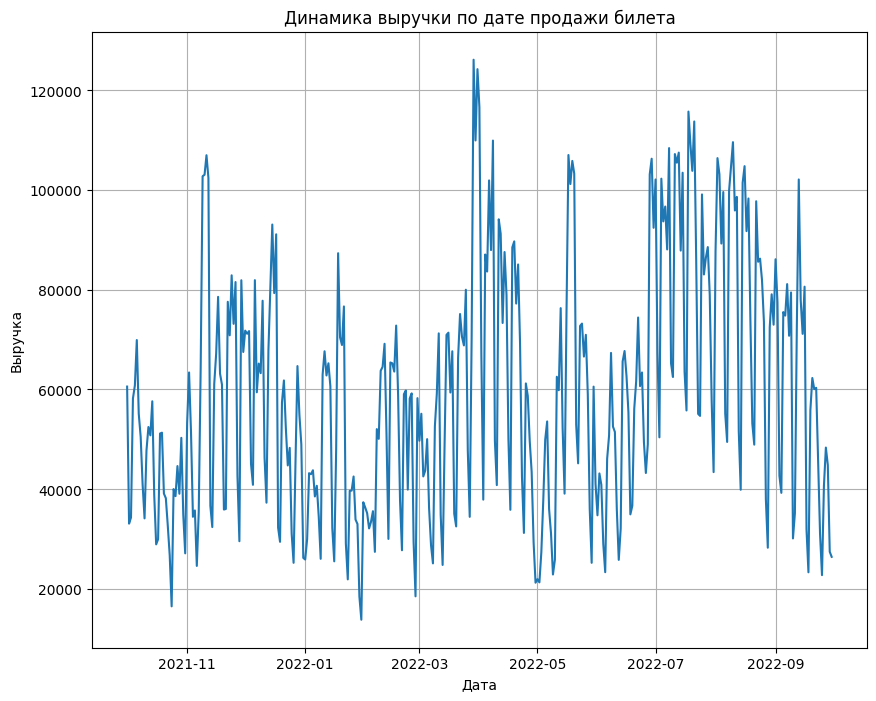

In [277]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = revenue_by_day, x = 'issue_date', y = 'revenue_amount').set(title = 'Динамика выручки по дате продажи билета', xlabel = 'Дата', ylabel = 'Выручка')
plt.grid()
plt.show()

По всему исследумеому периоду можно заметить несколько сильных колебаний: это колебание с ноября 2021 по январь 2022 года, с марта 2022 по май 2022 года и с июня 2022 по октябрь 2022. При этом, не смотря на то, что самая большая выручка была получена 29 марта 2022 года, составив 126120 у.е., на лето 2022 приходится наибольшее число пиковых значений, превышающих 100000 за день. Так, на июль пришлось 11 дней, в которые выручка была больше 100 тысяч, а на август - 6 таких дней. Самая низкая выручка была 30 января: за день она составила 13840 у.е.

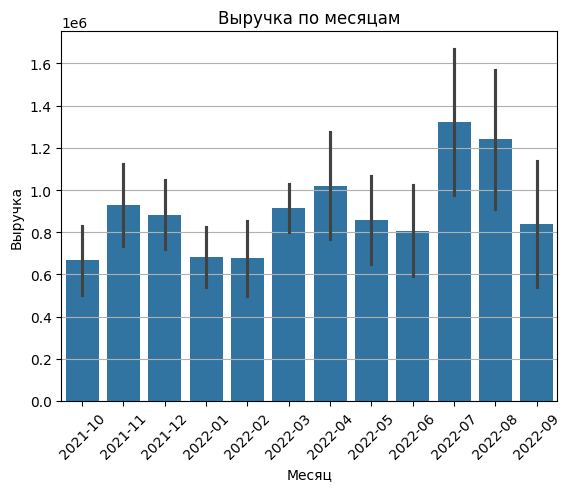

In [231]:
revenue_by_month = data.groupby([data['issue_date'].dt.to_period('M'), 'ffp_flag'])['revenue_amount'].sum().reset_index()
plt.grid()
sns.barplot(data = revenue_by_month, x = 'issue_date', y = 'revenue_amount').set(title = 'Выручка по месяцам', xlabel = 'Месяц', ylabel = 'Выручка')
plt.xticks(rotation = 45)
plt.show()

In [232]:
revenue_by_day.groupby(revenue_by_day['issue_date'].dt.month)['revenue_amount'].sum().sort_values(ascending=False)

issue_date
7     2643660.0
8     2479450.0
4     2040720.0
11    1857880.0
3     1833890.0
12    1767190.0
5     1714210.0
9     1678230.0
6     1616250.0
1     1363860.0
2     1354660.0
10    1334610.0
Name: revenue_amount, dtype: float64

При группировке по месяцам так же заметны волнообразные колебания. Наибольшая выручка была в июле, тогда она составила 2643660. Следующие значения по убыванию это авгус - 2479450 и апрель - 2040720. Наименьшая выручка была в октябре - 1334610.

In [233]:
tickets_by_day = data.groupby('issue_date')['revenue_amount'].count().reset_index()
tickets_by_day

,issue_date,revenue_amount
0,2021-10-01,163
1,2021-10-02,93
2,2021-10-03,110
3,2021-10-04,166
4,2021-10-05,166
...,...,...
360,2022-09-26,81
361,2022-09-27,90
362,2022-09-28,69
363,2022-09-29,55


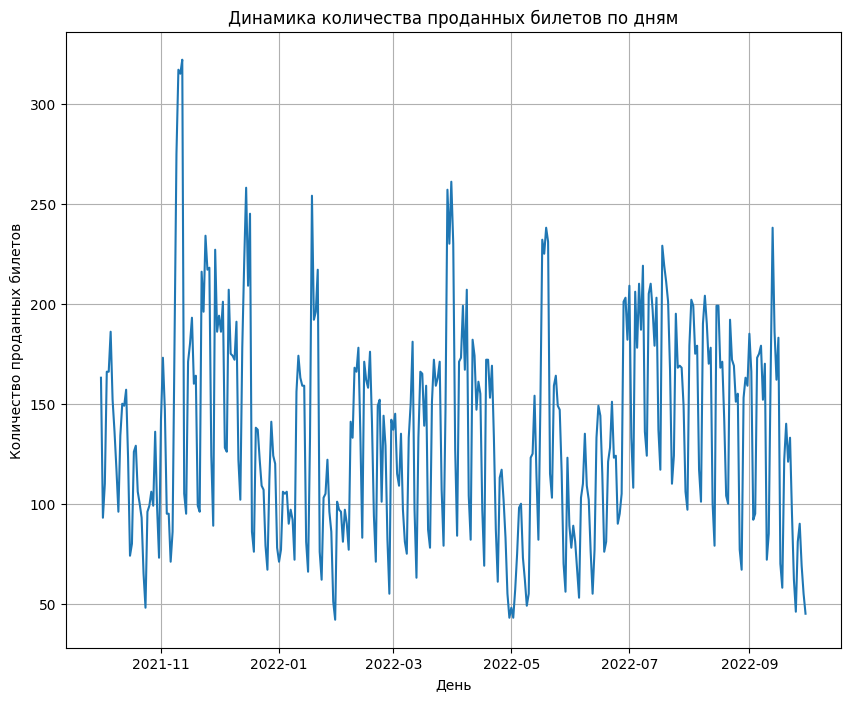

In [234]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = tickets_by_day, x = 'issue_date', y = 'revenue_amount').set(title = 'Динамика количества проданных билетов по дням', xlabel = 'День', ylabel = 'Количество проданных билетов')
plt.grid()
plt.show()

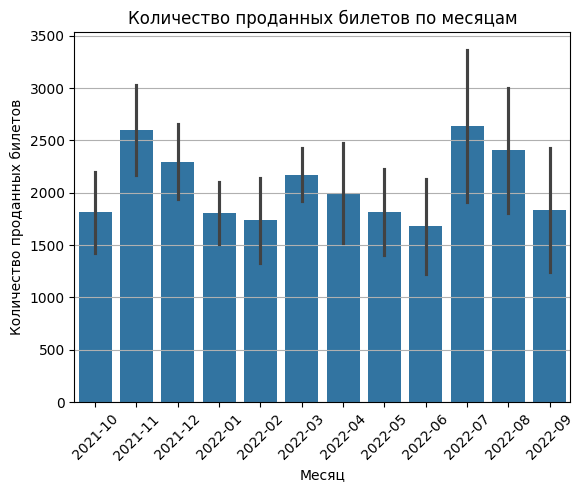

In [235]:
tickets_by_month = data.groupby([data['issue_date'].dt.to_period('M'), 'ffp_flag'])['revenue_amount'].count().reset_index()
plt.grid()
sns.barplot(data = tickets_by_month, x = 'issue_date', y = 'revenue_amount').set(title = 'Количество проданных билетов по месяцам', xlabel = 'Месяц', ylabel = 'Количество проданных билетов')
plt.xticks(rotation = 45)
plt.show()

In [236]:
print('День, в который купили больше всего билетов: ', revenue_by_month.loc[revenue_by_month['revenue_amount'].idxmax()])

День, в который купили больше всего билетов:  issue_date          2022-07
ffp_flag              False
revenue_amount    1668790.0
Name: 18, dtype: object


In [237]:
print('День, в который купили меньше всего билетов: ', revenue_by_month.loc[revenue_by_month['revenue_amount'].idxmin()])

День, в который купили меньше всего билетов:  issue_date         2022-02
ffp_flag              True
revenue_amount    499990.0
Name: 9, dtype: object


Колебания в динамике продажи билетов в целом совпадают с колебаниями по выручке, что характеризует данный показатель как ключевой в формировании прибыли. При этом день, в который было куцплено брольше всего билетов, не совпадает с днем с наибольшей выручкой: больше всего билетов купили 12 ноября 2021 года - 322 штуки. Меньше всего билетов купили 30 января - 42 штуки. Месяцем, в который продовалось больше всего билетов так же остается июль, за ним следует ноябрь, что говорит нам об увеличении средней цены билета, так как вторым по выручке месяцем выступает август.


## Динамика выручки в зависимости от использования программы лояльности FFP

### Подготовка данных

In [238]:
revenue_by_day_ffp = data.query('ffp_flag == True').groupby('issue_date')['revenue_amount'].sum().reset_index()   
revenue_by_day_not_ffp = data.query('ffp_flag == False').groupby('issue_date')['revenue_amount'].sum().reset_index()   

In [239]:
revenue_by_month = data.groupby([data['issue_date'].dt.to_period('M'),'ffp_flag'])['revenue_amount'].sum().reset_index()

In [240]:
revenue_ffp_n = data.query('ffp_flag == False').groupby(data['issue_date'].dt.to_period('M'))['revenue_amount'].mean().reset_index()
revenue_ffp_n

,issue_date,revenue_amount
0,2021-10,377.323944
1,2021-11,370.866116
2,2021-12,394.443606
3,2022-01,392.727706
4,2022-02,398.819412
5,2022-03,425.165017
6,2022-04,515.202102
7,2022-05,478.942870
8,2022-06,481.601691
9,2022-07,496.368233


In [241]:
data.groupby('ffp_flag')['revenue_amount'].count()

ffp_flag
False    30159
True     19372
Name: revenue_amount, dtype: int64

In [242]:
data.groupby(data['issue_date'].dt.to_period('M'))['ffp_flag'].count()

issue_date
2021-10    3626
2021-11    5190
2021-12    4585
2022-01    3610
2022-02    3469
2022-03    4342
2022-04    3989
2022-05    3623
2022-06    3356
2022-07    5271
2022-08    4804
2022-09    3666
Freq: M, Name: ffp_flag, dtype: int64

In [243]:
revenue_ffp_y = data.query('ffp_flag == True').groupby(data['issue_date'].dt.to_period('M'))['revenue_amount'].mean().reset_index()
revenue_ffp_y

,issue_date,revenue_amount
0,2021-10,353.768421
1,2021-11,339.958430
2,2021-12,373.071355
3,2022-01,357.111699
4,2022-02,377.066365
5,2022-03,418.816475
6,2022-04,505.683168
7,2022-05,463.942857
8,2022-06,481.597392
9,2022-07,510.670508


### Графики и выводы

[Text(0.5, 1.0, 'Динамика выручки по дате продажи билета в зависимости от участия в программе лояльности'),
 Text(0.5, 0, 'Дата'),
 Text(0, 0.5, 'Выручка')]

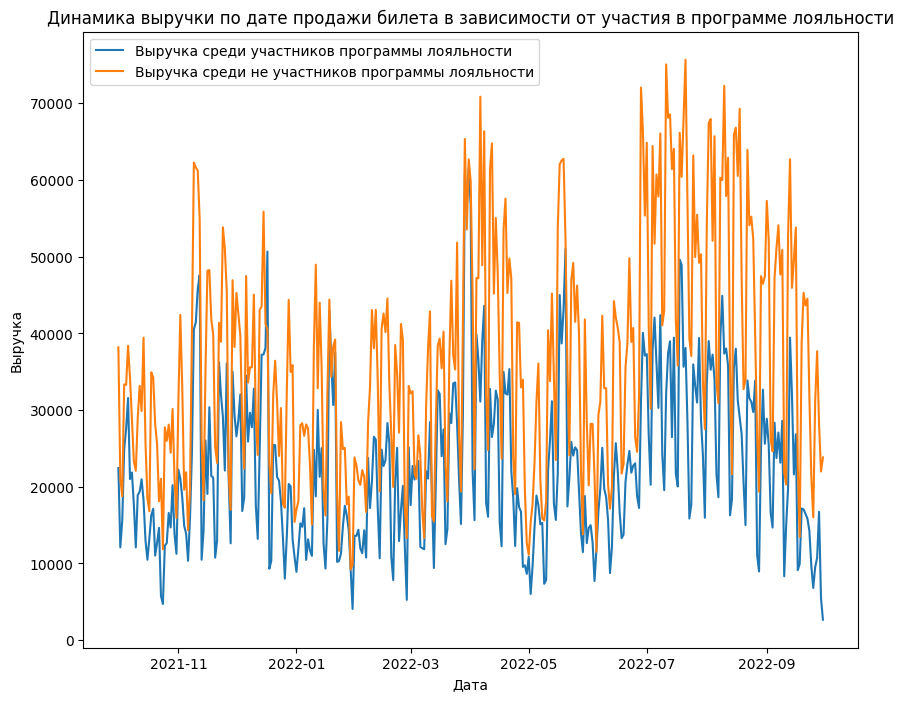

In [244]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = revenue_by_day_ffp, x = 'issue_date', y = 'revenue_amount', label='Выручка среди участников программы лояльности')
sns.lineplot(data = revenue_by_day_not_ffp, x = 'issue_date', y = 'revenue_amount', label='Выручка среди не участников программы лояльности').set(title = 'Динамика выручки по дате продажи билета в зависимости от участия в программе лояльности', xlabel = 'Дата', ylabel = 'Выручка')

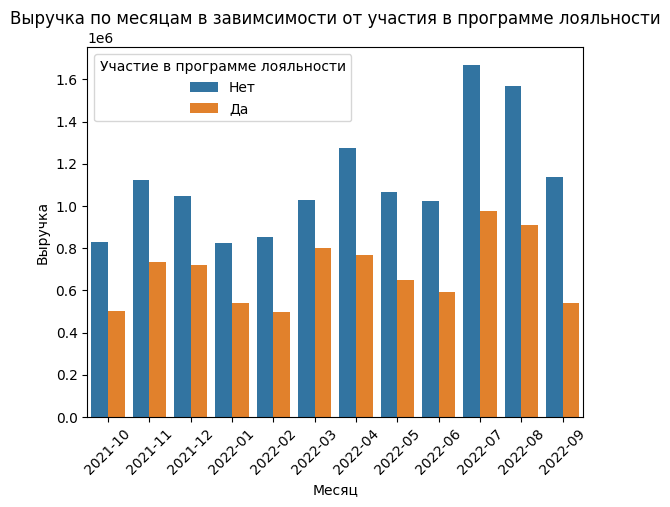

In [245]:
ax = sns.barplot(data=revenue_by_month,  x='issue_date', y='revenue_amount', hue='ffp_flag', hue_order=[False, True])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Нет', 'Да'], title='Участие в программе лояльности')
plt.xticks(rotation = 45)
plt.title('Выручка по месяцам в завимсимости от участия в программе лояльности')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.show()

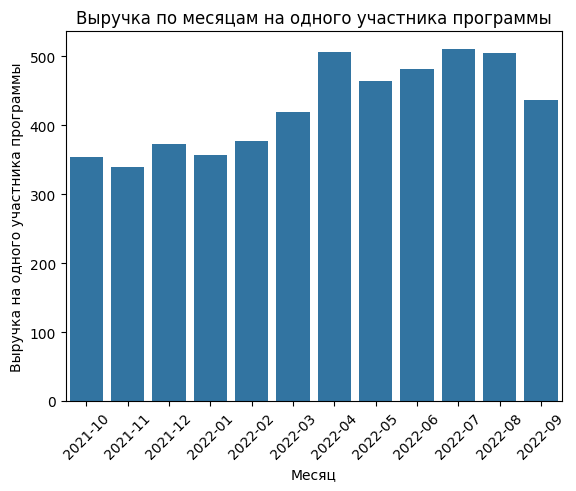

In [246]:
ax = sns.barplot(data=revenue_ffp_y,  x='issue_date', y='revenue_amount')
plt.xticks(rotation = 45)
plt.title('Выручка по месяцам на одного участника программы')
plt.xlabel('Месяц')
plt.ylabel('Выручка на одного участника программы')
plt.show()

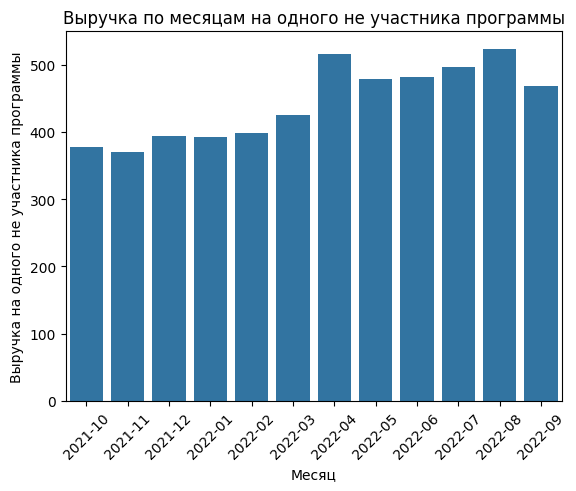

In [247]:
ax = sns.barplot(data=revenue_ffp_n,  x='issue_date', y='revenue_amount')
plt.xticks(rotation = 45)
plt.title('Выручка по месяцам на одного не участника программы')
plt.xlabel('Месяц')
plt.ylabel('Выручка на одного не участника программы')
plt.show()

В целом, на протяжении всего периода выручка от покупки билетов участниками программы была меньше, чем выручка от покупки билетов не участниками программы. Лучше это заметно на графике по месяцам: в каждом периоде выручка от не участников программы лояльности превышает выручку от участников примерно на 30-40%. Тем не менее стоит учесть, что количество участников программы примерно в 1,5 раза меньше остальных покупателей, потому разумнее рассмотреть относительные значения. По последним двум графикам видно, что значения практически не отличаются и колебания проходят в те же месяцы.

## Анализ выручки в зависимости от типа рейса

### Подготовка данных

In [248]:
revenue_by_month_v = data.query('route_flight_type == "ВВЛ"').groupby('issue_date')['revenue_amount'].sum().reset_index()   
revenue_by_month_m= data.query('route_flight_type == "МВЛ"').groupby('issue_date')['revenue_amount'].sum().reset_index()   
revenue_by_month_v

,issue_date,revenue_amount
0,2021-10-01,45980.0
1,2021-10-02,26730.0
2,2021-10-03,25940.0
3,2021-10-04,48310.0
4,2021-10-05,47580.0
...,...,...
360,2022-09-26,37340.0
361,2022-09-27,41900.0
362,2022-09-28,31430.0
363,2022-09-29,22240.0


In [249]:
revenue_by_month = data.groupby([data['issue_date'].dt.to_period('M'), 'route_flight_type'])['revenue_amount'].sum().reset_index()

In [250]:
revenue_by_month.query('route_flight_type == "МВЛ"').sort_values(by='revenue_amount')

,issue_date,route_flight_type,revenue_amount
11,2022-03,МВЛ,37390.0
15,2022-05,МВЛ,78180.0
17,2022-06,МВЛ,91180.0
13,2022-04,МВЛ,106780.0
21,2022-08,МВЛ,118090.0
19,2022-07,МВЛ,132170.0
23,2022-09,МВЛ,142150.0
9,2022-02,МВЛ,175430.0
7,2022-01,МВЛ,207470.0
1,2021-10,МВЛ,291840.0


In [251]:
revenue_by_month.query('route_flight_type == "ВВЛ"').sort_values(by='revenue_amount')

,issue_date,route_flight_type,revenue_amount
0,2021-10,ВВЛ,1042770.0
6,2022-01,ВВЛ,1156390.0
8,2022-02,ВВЛ,1179230.0
4,2021-12,ВВЛ,1457850.0
16,2022-06,ВВЛ,1525070.0
2,2021-11,ВВЛ,1533700.0
22,2022-09,ВВЛ,1536080.0
14,2022-05,ВВЛ,1636030.0
10,2022-03,ВВЛ,1796500.0
12,2022-04,ВВЛ,1933940.0


### Графики и выводы

[Text(0.5, 1.0, 'Выручка по дням за внутренние/внешние рейсы'),
 Text(0.5, 0, 'Дата'),
 Text(0, 0.5, 'Выручка')]

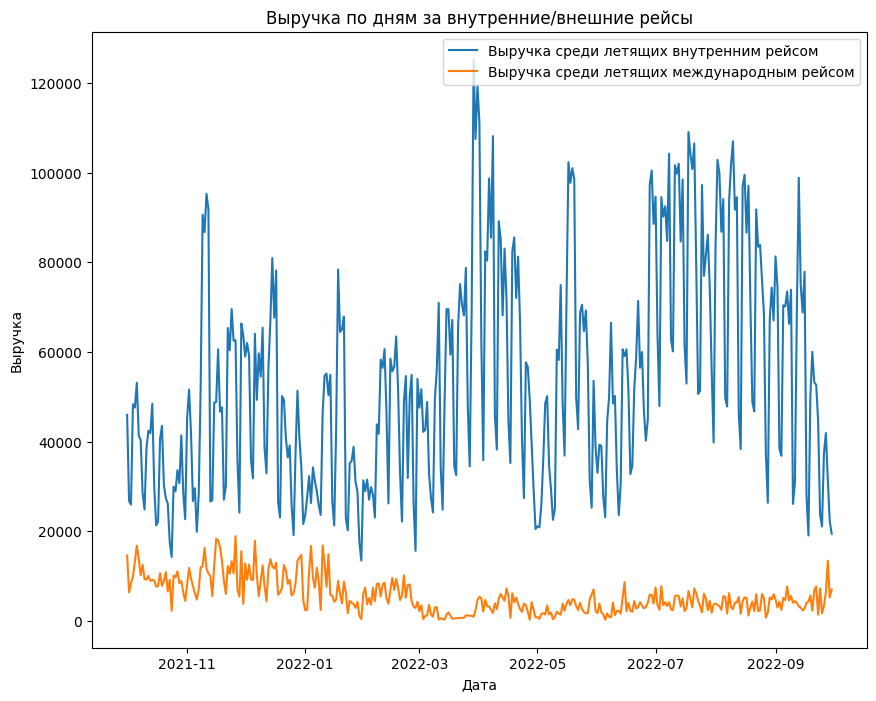

In [252]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = revenue_by_month_v, x = 'issue_date', y = 'revenue_amount', label='Выручка среди летящих внутренним рейсом')
sns.lineplot(data = revenue_by_month_m, x = 'issue_date', y = 'revenue_amount', label='Выручка среди летящих международным рейсом').set(title = 'Выручка по дням за внутренние/внешние рейсы', xlabel = 'Дата', ylabel = 'Выручка')

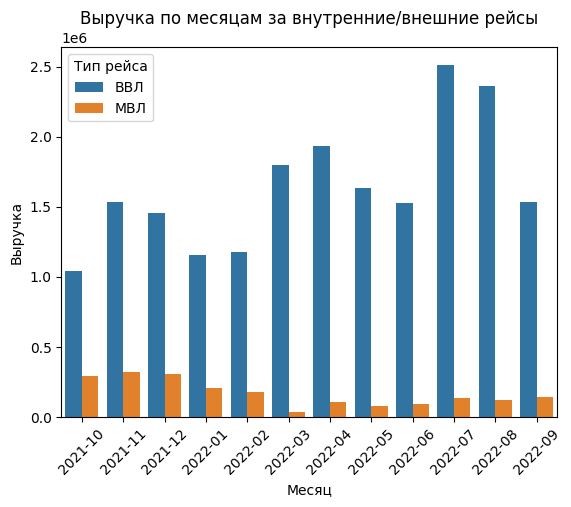

In [253]:
sns.barplot(data = revenue_by_month, x = 'issue_date', y = 'revenue_amount', hue='route_flight_type').set(title = 'Выручка по месяцам за внутренние/внешние рейсы', xlabel = 'Месяц', ylabel = 'Выручка', )
plt.xticks(rotation = 45)
plt.legend(title='Тип рейса')
plt.show()

По получившимся графикам можно заметить, что выручка с международных рейсов сильно меньше выручки с внутренних рейсов. Так, пиковое значение выручки среди международных рейсов пришлось на ноярь и составило 324180, а пикеовое значение среди внутренних рейсов - 2511490.

## Анализ выручки в зависимости от типа продажи билета

### Подготовка данных

In [254]:
data['sale_type'].unique()

array(['ONLINE', 'OFFLINE'], dtype=object)

In [255]:
revenue_by_day_on = data.query('sale_type == "ONLINE"').groupby('issue_date')['revenue_amount'].sum().reset_index()   
revenue_by_day_of= data.query('sale_type == "OFFLINE"').groupby('issue_date')['revenue_amount'].sum().reset_index()

In [256]:
revenue_by_month_sale = data.groupby([data['issue_date'].dt.to_period('M'), 'sale_type'])['revenue_amount'].sum().reset_index()

In [257]:
revenue_by_month_sale.query('sale_type == "ONLINE"').sort_values(by='revenue_amount')

,issue_date,sale_type,revenue_amount
9,2022-02,ONLINE,679380.0
1,2021-10,ONLINE,679880.0
7,2022-01,ONLINE,729720.0
23,2022-09,ONLINE,798670.0
17,2022-06,ONLINE,860850.0
5,2021-12,ONLINE,905190.0
3,2021-11,ONLINE,953210.0
15,2022-05,ONLINE,970180.0
13,2022-04,ONLINE,1000160.0
11,2022-03,ONLINE,1032060.0


In [258]:
revenue_by_month_sale.query('sale_type == "ONLINE"')['revenue_amount'].mean()

np.float64(942027.5)

In [259]:
revenue_by_month_sale.query('sale_type == "OFFLINE"').sort_values(by='revenue_amount')

,issue_date,sale_type,revenue_amount
6,2022-01,OFFLINE,634140.0
0,2021-10,OFFLINE,654730.0
8,2022-02,OFFLINE,675280.0
14,2022-05,OFFLINE,744030.0
16,2022-06,OFFLINE,755400.0
10,2022-03,OFFLINE,801830.0
4,2021-12,OFFLINE,862000.0
22,2022-09,OFFLINE,879560.0
2,2021-11,OFFLINE,904670.0
12,2022-04,OFFLINE,1040560.0


In [260]:
revenue_by_month_sale.query('sale_type == "OFFLINE"')['revenue_amount'].mean()

np.float64(865023.3333333334)

### Графики и выводы

[Text(0.5, 1.0, 'Динамика выручки по дням за билеты купленные онлайн/оффлайн'),
 Text(0.5, 0, 'Дата'),
 Text(0, 0.5, 'Выручка')]

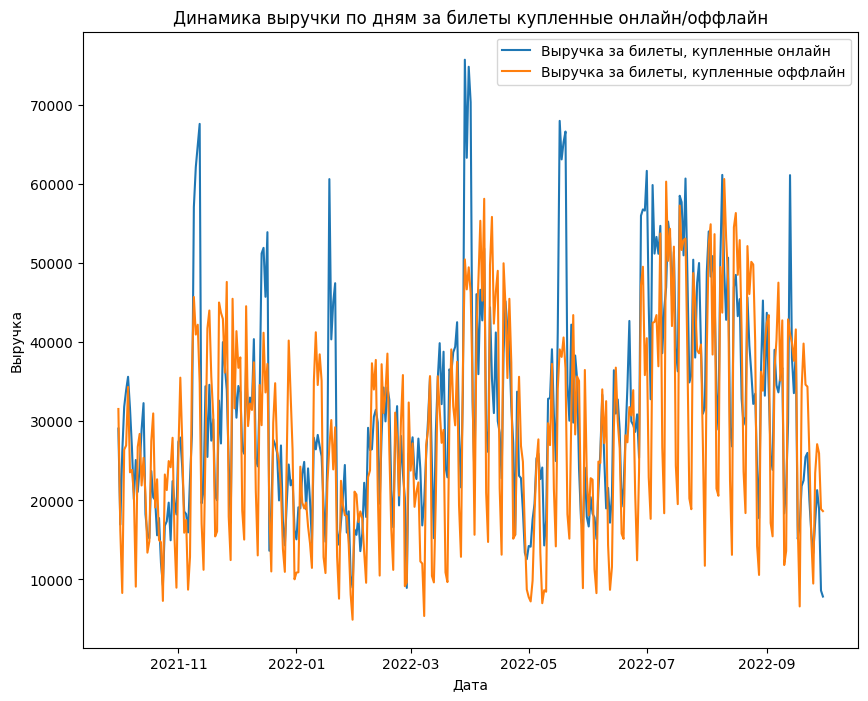

In [261]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = revenue_by_day_on, x = 'issue_date', y = 'revenue_amount', label='Выручка за билеты, купленные онлайн')
sns.lineplot(data = revenue_by_day_of, x = 'issue_date', y = 'revenue_amount', label='Выручка за билеты, купленные оффлайн').set(title = 'Динамика выручки по дням за билеты купленные онлайн/оффлайн', xlabel = 'Дата', ylabel = 'Выручка')

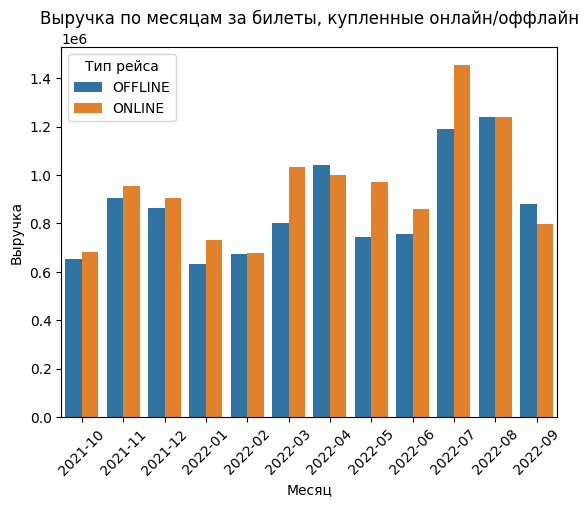

In [262]:
sns.barplot(data = revenue_by_month_sale, x = 'issue_date', y = 'revenue_amount', hue='sale_type').set(title = 'Выручка по месяцам за билеты, купленные онлайн/оффлайн', xlabel = 'Месяц', ylabel = 'Выручка', )
plt.xticks(rotation = 45)
plt.legend(title='Тип рейса')
plt.show()

По графикам заметно, что большую часть времени выручка с билетов, купленных оффлайн немного уступает выручке с билетов, купленных онлайн. Оффлан превышает онлайн лишь в апреле и сентябре. Самое больше значение выручки при онлайн покупке в июле - 1454560, при оффлайн в августе - 1238980. Самое маленькое значение при покупке онлайн в феврале - 679380. При оффлайн в январе - 634140. Среднее значение выручки при покупке онлайн - 942027.5, при покупке оффлайн - 865023.3.

## Анализ выручки по типам пассажиров

### Подготовка данных

In [263]:
data['pax_type'].unique()

array(['AD', 'CHD', 'INF'], dtype=object)

In [264]:
revenue_by_day_ad = data.query('pax_type == "AD"').groupby('issue_date')['revenue_amount'].sum().reset_index()   
revenue_by_day_chd = data.query('pax_type == "CHD"').groupby('issue_date')['revenue_amount'].sum().reset_index()
revenue_by_day_inf = data.query('pax_type == "INF"').groupby('issue_date')['revenue_amount'].sum().reset_index()

In [265]:
revenue_by_day_pas = data.groupby(['issue_date', 'pax_type'])['revenue_amount'].sum().reset_index()
revenue_by_day_pas.query('pax_type == "AD"')['revenue_amount'].mean()

np.float64(55724.191780821915)

In [266]:
revenue_by_day_pas.query('pax_type == "CHD"')['revenue_amount'].mean()

np.float64(3679.2011019283746)

In [267]:
revenue_by_day_pas.query('pax_type == "INF"')['revenue_amount'].mean()

np.float64(129.73333333333332)

### График и выводы

[Text(0.5, 1.0, 'Динамика выручки по дням за билеты купленные различным категориям пассажиров'),
 Text(0.5, 0, 'Дата'),
 Text(0, 0.5, 'Выручка')]

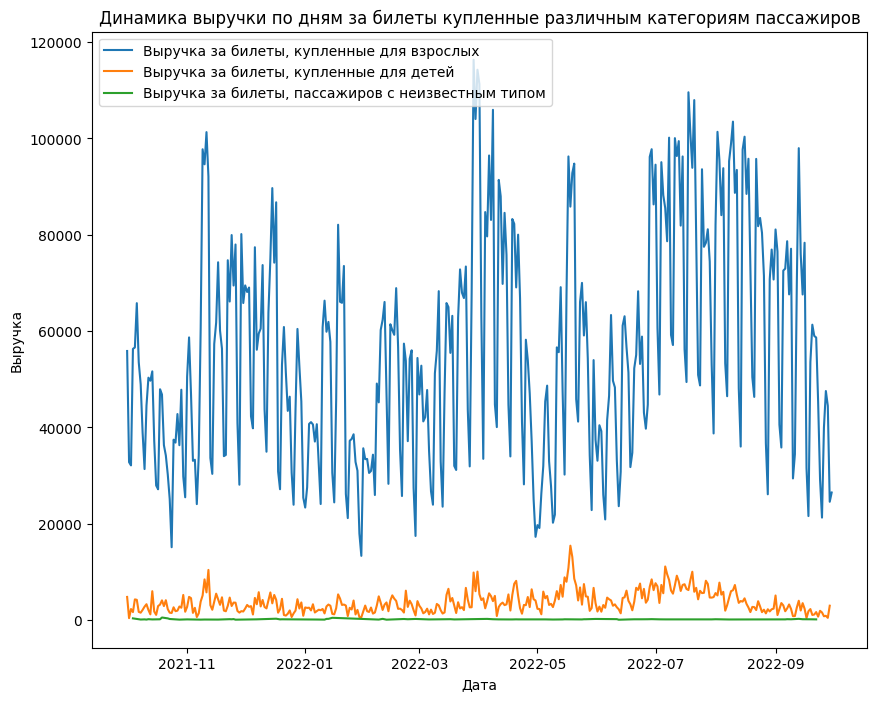

In [268]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = revenue_by_day_ad, x = 'issue_date', y = 'revenue_amount', label='Выручка за билеты, купленные для взрослых')
sns.lineplot(data = revenue_by_day_chd, x = 'issue_date', y = 'revenue_amount', label='Выручка за билеты, купленные для детей')
sns.lineplot(data = revenue_by_day_inf, x = 'issue_date', y = 'revenue_amount', label='Выручка за билеты, пассажиров с неизвестным типом').set(title = 'Динамика выручки по дням за билеты купленные различным категориям пассажиров', xlabel = 'Дата', ylabel = 'Выручка')

По общему графику выручки по дням видно, что в любой день выручка с пролдажи взрослых билетов значительно превышает выручку с продажи детских билетов и с продажи билетов без указания типа. Так, средняя выручка с взрослых билетов за весь период - 55724.2, с детских - 3679.2, а с билетов без указания типа - 129.7.

# Удаление выбросов

## Исследование выручки

In [ ]:
# Построим boxplot для осознания проблемы
plt.figure(figsize=(10, 6))
sns.boxplot(x='issue_date', y='revenue_amount', data=data)